In [2]:
import JC
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

In [ ]:
df=pd.read_excel()

In [131]:
df_arimax=pd.read_csv('szzs1000-100-1.csv')
df_arima=pd.read_csv('pred_res11268000.csv')
#df_arima=pd.read_csv('1223arima(000300).csv')
true=df_arima['true_logret']

In [132]:
def long_short_analysis_single_smooth(
    y_true,
    single_pred_logret,
    k=2,
    target_long=0.75,
    target_short=0.75,
    smooth_alpha=20.0   # 越大越接近硬切换
):
    mu = y_true.mean()
    sigma = y_true.std() + 1e-8

    duo = mu + k * sigma
    kong = mu - k * sigma

    beta_long = np.arctanh(target_long) / duo
    beta_short = np.arctanh(-target_short) / kong

    x = single_pred_logret

    # -------- 平滑权重（连续可导）--------
    w = 1 / (1 + np.exp(-smooth_alpha * x))   # sigmoid

    # -------- 平滑 beta --------
    beta = w * beta_long + (1 - w) * beta_short
    print(beta_long,beta_short,beta)

    # -------- 输出 --------
    return np.tanh(beta * x)


def JC_metric(df,
              window=200,
              ann_factor=252,
              gamma=50,
              Lmax=5,
              k=50,
              learned_scale=None):   # ★ 可学习的 scale
    """
    df 必含 pred_logret, true_logret
    learned_scale: 若 None 则用1.0；训练时可作为 nn.Parameter()
    """

    pred = torch.tensor(df['pred_logret'].values, dtype=torch.float32)
    true = torch.tensor(df['true_logret'].values, dtype=torch.float32)

    # --- 1) 先做静态 std scaling（初始化校正） ---
    ratio = true.std() / (pred.std() + 1e-8)
    pred_scaled = pred * ratio

    # --- 2) 再乘动态 learnable scale（训练中自动调优） ---
    if learned_scale is None:
        learned_scale = torch.tensor(1.0, dtype=torch.float32)

    pred_final = learned_scale * pred_scaled

    N = len(df)

    # --- 3) 滚动年化波动 ---
    returns = true.numpy()
    sigmas = []
    for t in range(N):
        if t < window - 1:
            sigmas.append(1e-6)   # 或 np.nan / sigma_window
        else:
            r_w = returns[t-window+1 : t+1]
            sigmas.append(
                np.sqrt(np.mean(r_w**2)) * np.sqrt(ann_factor)
            )

    sigma_ann = torch.tensor(sigmas, dtype=torch.float32)


    # --- 4) 杠杆 ---
    raw_leverage = k * pred_final / (sigma_ann + 1e-8)
    L_t = Lmax * torch.clamp(raw_leverage, -1.0, 1.0)

    # --- 5) 杠杆后的真实收益 ---
    levered_r = L_t * true

    # --- 6) Equity curve ---
    E = torch.cumsum(levered_r, dim=0)

    # --- 7) Soft running max ---
    M_soft = torch.stack([torch.logsumexp(gamma * E[:t+1], dim=0) / gamma
                          for t in range(N)])

    DD_soft = M_soft - E
    MDD_soft = torch.logsumexp(gamma * DD_soft, dim=0) / gamma

    total_ret = E[-1]
    JC = total_ret / (MDD_soft + 1e-8)

    return JC, {
        'L_t': L_t.detach().numpy(),
        'E': E.detach().numpy(),
        'DD_soft': DD_soft.detach().numpy(),
        'MDD_soft': float(MDD_soft.detach()),
        'total_return': float(total_ret.detach()),
        'scale_used': float(learned_scale.detach())
    }


In [149]:
import torch
import numpy as np

def rolling_std_torch(x, window, eps=1e-8):
    """
    x: 1D torch tensor, shape [T]
    return: rolling std (RMS), shape [T]
    """
    T = len(x)
    out = torch.zeros(T, dtype=x.dtype, device=x.device)

    for t in range(T):
        if t < window - 1:
            out[t] = torch.sqrt(torch.mean(x[:t+1] ** 2) + eps)
        else:
            out[t] = torch.sqrt(torch.mean(x[t-window+1:t+1] ** 2) + eps)

    return out

def JC_metric(
    df,
    window=200,
    ann_factor=252,
    gamma=50,
    Lmax=5,
    k=50,
    learned_scale=None,
    eps=1e-4
):
    """
    杠杆生成：用你现有逻辑
    JC 评价：严格按图片公式
    """

    # =============================
    # 0. 数据
    # =============================
    pred = torch.tensor(df['pred_logret'].values, dtype=torch.float32)
    true = torch.tensor(df['true_logret'].values, dtype=torch.float32)

    T = len(df)

    # =============================
    # 1. 静态 std scaling
    # =============================
    std_true = rolling_std_torch(true, window)
    std_pred = rolling_std_torch(pred, window)
    ratio = std_true.std() / (std_pred.std() + eps)
    pred_scaled = pred * ratio

    # =============================
    # 2. learnable scale
    # =============================
    if learned_scale is None:
        learned_scale = torch.tensor(1.0, dtype=torch.float32)

    pred_final = learned_scale * pred_scaled

    # =============================
    # 3. rolling 年化波动
    # =============================
    returns_np = true.detach().numpy()
    sigmas = []

    for t in range(T):
        if t < window - 1:
            sigmas.append(1e-6)
        else:
            r_w = returns_np[t-window+1 : t+1]
            sigmas.append(np.sqrt(np.mean(r_w**2)) * np.sqrt(ann_factor))

    sigma_ann = torch.tensor(sigmas, dtype=torch.float32)

    # =============================
    # 4. 杠杆（完全保留）
    # =============================
    raw_leverage = k * pred_final / (sigma_ann + eps)
    L_t = Lmax * torch.clamp(raw_leverage, -1.0, 1.0)

    # =============================
    # 5. 单期策略收益
    # =============================
    pnl = L_t * true   # 对应 L_t * r_t^{return}

    # =============================
    # 6. 累计收益曲线 E_t
    # =============================
    E = torch.cumsum(pnl, dim=0)

    # =============================
    # 7. soft running max → DD_t
    # =============================
    M_soft = torch.stack([
        torch.logsumexp(gamma * E[:t+1], dim=0) / gamma
        for t in range(T)
    ])

    DD = M_soft - E   # soft DD_t

    # =============================
    # 8. 图片定义的风险调整系数 k_JC
    # k = sqrt(252 / mean(L_t^2))
    # =============================
    mean_L2 = torch.mean(L_t ** 2)
    k_JC = torch.sqrt(ann_factor / (mean_L2 + eps))

    # =============================
    # 9. JC 分子 & 分母（严格定义）
    # =============================
    numerator = k_JC * torch.mean(pnl)
    denominator = torch.sqrt(torch.mean(DD ** 2) + eps)

    JC = numerator / denominator

    return JC, {
        'L_t': L_t.detach().numpy(),
        'E': E.detach().numpy(),
        'DD_soft': DD.detach().numpy(),
        'mean_L2': float(mean_L2.detach()),
        'k_JC': float(k_JC.detach()),
        'numerator': float(numerator.detach()),
        'denominator': float(denominator.detach()),
        'scale_used': float(learned_scale.detach())
    }
def JC_metric_bench(
    df,
    ann_factor=252,
    gamma=50,
    eps=1e-8
):
    """
    Benchmark JC：Lt ≡ 1
    """

    true = torch.tensor(df['true_logret'].values, dtype=torch.float32)
    T = len(true)

    # =============================
    # 1. Bench 杠杆
    # =============================
    L_t = torch.ones_like(true)

    # =============================
    # 2. 单期收益
    # =============================
    pnl = L_t * true   # 就是 true 本身

    # =============================
    # 3. 累计收益 E_t
    # =============================
    E = torch.cumsum(pnl, dim=0)

    # =============================
    # 4. soft running max & DD
    # =============================
    M_soft = torch.stack([
        torch.logsumexp(gamma * E[:t+1], dim=0) / gamma
        for t in range(T)
    ])

    DD = M_soft - E

    # =============================
    # 5. k_JC（此时 mean(L^2)=1）
    # =============================
    mean_L2 = torch.mean(L_t ** 2)   # =1
    k_JC = torch.sqrt(ann_factor / (mean_L2))

    # =============================
    # 6. JC
    # =============================
    numerator = k_JC * torch.mean(pnl)
    denominator = torch.sqrt(torch.mean(DD ** 2) )

    JC = numerator / denominator

    return JC, {
        'E': E.detach().numpy(),
        'DD_soft': DD.detach().numpy(),
        'k_JC': float(k_JC),
        'numerator': float(numerator),
        'denominator': float(denominator)
    }


In [150]:

JC_bench=JC_metric_bench(df_arima[:])
JC_bench[0]*JC_bench[1]['k_JC']


tensor(0.1313)

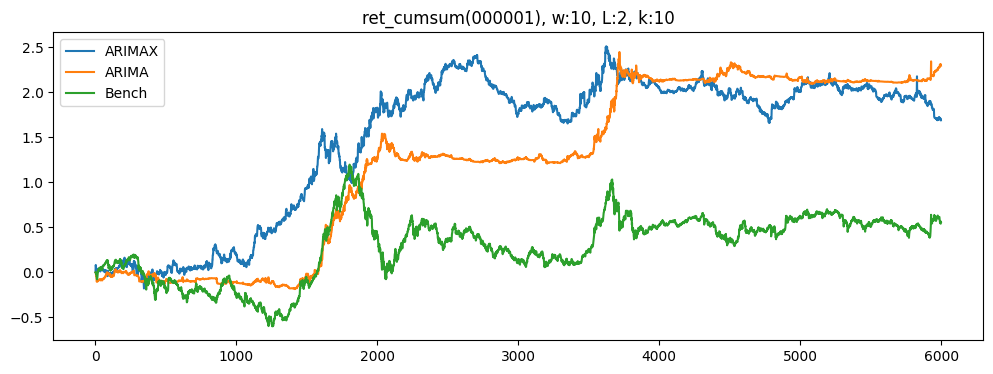

ARIMAX: tensor(0.0088)
ARIMA: tensor(0.0349)
Bench: tensor(0.0083)


In [152]:
# JC1=JC.JC_metric1(df_arimax[-5000:-1000], window=50, Lmax=10, k=2)
# JC2=JC.JC_metric1(df_arima[-5000:-1000], window=50, Lmax=10, k=2)
w=10
L=2
k=10
JC1=JC_metric(df_arimax[-6000:], window=w, Lmax=L,k=k)
JC2=JC_metric(df_arima[-6000:], window=w, Lmax=L, k=k)
E1=JC1[1]['E']
E2=JC2[1]['E']
plt.figure(figsize=(12,4))
plt.plot(E1,label='ARIMAX')
plt.plot(E2,label='ARIMA')
plt.plot(np.array(list(true[-6000:])).cumsum(),label='Bench')
plt.title('ret_cumsum(000001), w:{}, L:{}, k:{}'.format(w, L, k))
plt.legend()
plt.show()
print('ARIMAX:',JC1[0])
print('ARIMA:',JC2[0])
print('Bench:',JC_bench[0])

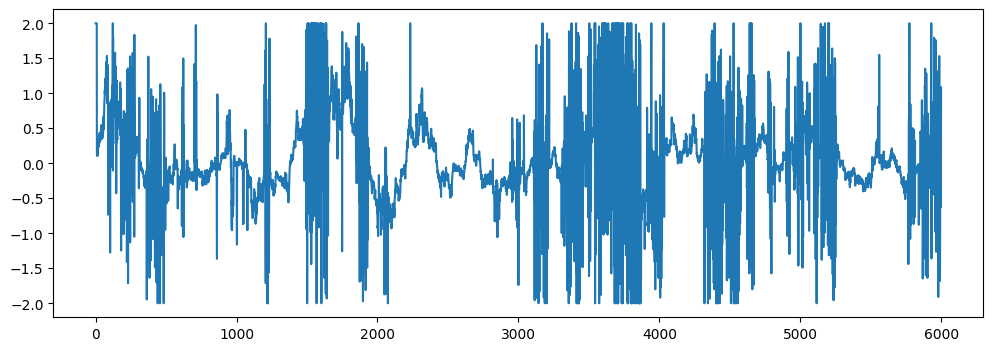

In [153]:
L_t=JC2[1]['L_t']
plt.figure(figsize=(12,4))
plt.plot(L_t)

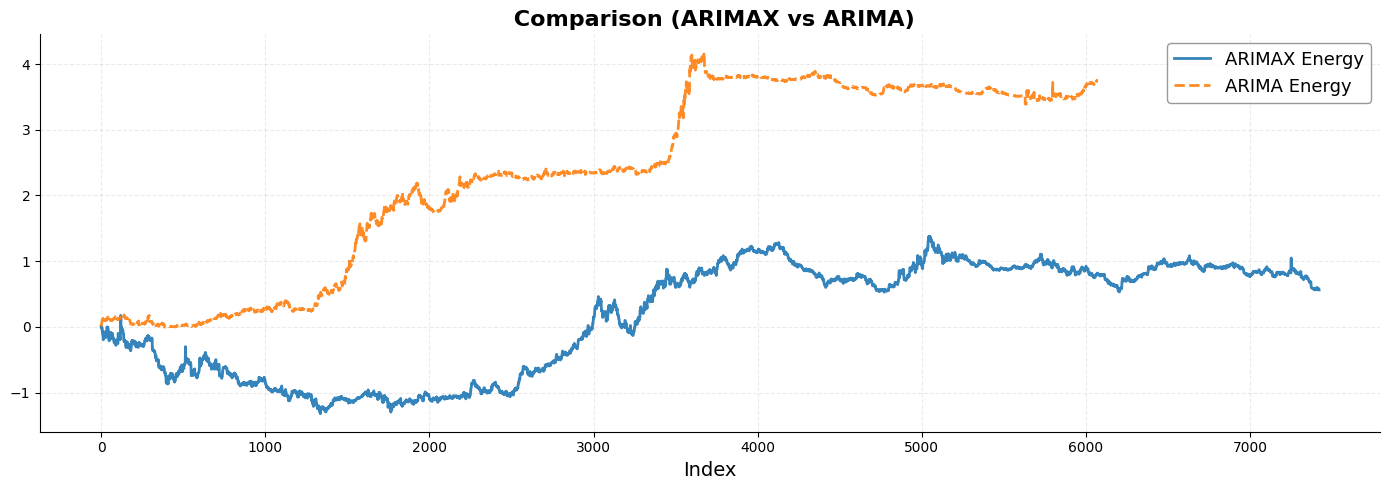

In [105]:
plt.figure(figsize=(14, 5))

# 线条风格
plt.plot(E1, label='ARIMAX Energy', linewidth=2.0, alpha=0.9)
plt.plot(E2, label='ARIMA Energy', linewidth=2.0, linestyle='--', alpha=0.9)

# 标题 + 坐标轴标签
plt.title(" Comparison (ARIMAX vs ARIMA)", fontsize=16, fontweight='bold')
plt.xlabel("Index", fontsize=14)
#plt.ylabel("Energy (E)", fontsize=14)

# 网格更柔和
plt.grid(alpha=0.25, linestyle='--')

# 图例
plt.legend(fontsize=13, frameon=True, shadow=False, facecolor='white', edgecolor='gray')

# 边框柔化（右、上框隐藏）
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 调整整体边距
plt.tight_layout()

plt.show()


In [123]:
print(JC1)
print(JC1[0]*JC1[1]['k_JC'])

(tensor(0.0164), {'L_t': array([-1., -1., -1., ...,  1.,  1.,  1.], shape=(6000,), dtype=float32), 'E': array([5.4573844e-04, 1.6688023e-02, 3.9338931e-02, ..., 1.6120733e+00,
       1.6124895e+00, 1.6045794e+00], shape=(6000,), dtype=float32), 'DD_soft': array([0.        , 0.00737801, 0.00765027, ..., 0.6297091 , 0.62929296,
       0.637203  ], shape=(6000,), dtype=float32), 'mean_L2': 0.9124586582183838, 'k_JC': 16.61857032775879, 'numerator': 0.0044443029910326, 'denominator': 0.2714138627052307, 'scale_used': 1.0})
tensor(0.2721)


In [108]:
print(JC2)
print(JC2[0]*JC2[1]['k_JC'])

(tensor(0.0191), {'L_t': array([ 1.,  1.,  1., ..., -1., -1.,  1.], shape=(6000,), dtype=float32), 'E': array([-0.00323745, -0.00522741, -0.0073686 , ...,  2.068152  ,
        2.0431008 ,  2.0388277 ], shape=(6000,), dtype=float32), 'DD_soft': array([0.        , 0.01488266, 0.02413401, ..., 0.05412579, 0.07955503,
       0.08412838], shape=(6000,), dtype=float32), 'mean_L2': 0.7015420198440552, 'k_JC': 18.952802658081055, 'numerator': 0.006440248806029558, 'denominator': 0.3374267816543579, 'scale_used': 1.0})
tensor(0.3617)


In [104]:
JC2[1]['L_t']

array([ 2.,  2.,  2., ..., -2., -2.,  2.], shape=(6000,), dtype=float32)

(array([20.00001907,  0.17499965,  0.07500007,  0.12500012,  0.09166648,
         0.1000001 ,  0.15833348,  0.16666683,  0.10833311,  0.1000001 ,
         0.11666643,  0.08333341,  0.08333341,  0.15833348,  0.15000014,
         0.13333306,  0.14166638,  0.11666678,  0.10833344,  0.13333346,
         0.19166685,  0.15833301,  0.12500012,  0.12499975,  0.16666683,
         0.1000001 ,  0.15833348,  0.17499965,  0.12500012,  0.10833344,
         0.15833301,  0.11666678,  0.16666683,  0.10833311,  0.13333346,
         0.09166675,  0.13333306,  0.12500012,  0.05833339,  0.1416668 ,
         0.13333306,  0.11666678,  0.12500012,  0.1499997 ,  0.10833344,
         0.16666683,  0.08333316,  0.1416668 ,  0.17500017,  0.14166638,
         0.1416668 ,  0.10833344,  0.10833344,  0.15000014,  0.05833304,
         0.1000001 ,  0.13333346,  0.15000014,  0.15000014,  0.08333341,
         0.12499937,  0.10833344,  0.1000001 ,  0.1416668 ,  0.1416668 ,
         0.08333341,  0.11666678,  0.07499962,  0.1

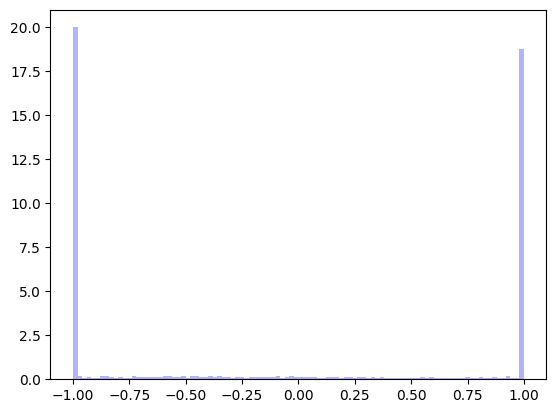

In [90]:
plt.hist(JC2[1]['L_t'], bins=100, alpha=0.3, label='True Hist', color='blue', density=True)

In [91]:
import numpy as np

def compute_JC(L_hat, r_return, ann_factor=252, eps=1e-12):
    """
    JC 指标计算（严格按图片中的数学定义）

    Parameters
    ----------
    L_hat : array-like, shape (T,)
        每期杠杆 / 仓位  \hat{L}_t
    r_return : array-like, shape (T,)
        每期真实收益率 r_t^{return}
    ann_factor : int
        年化因子（日频 = 252）
    eps : float
        数值稳定项

    Returns
    -------
    JC : float
    info : dict
        中间变量（E_t, DD_t, k 等）
    """

    L_hat = np.asarray(L_hat, dtype=float)
    r_return = np.asarray(r_return, dtype=float)
    assert L_hat.shape == r_return.shape

    T = len(L_hat)

    # =============================
    # 1. 单期策略收益 L_t * r_t
    # =============================
    pnl = L_hat * r_return  # 对应 \hat{L}_t · r_t^{return}

    # =============================
    # 2. 累计收益曲线 E_t
    # E_t = sum_{i=1}^t (L_i r_i)
    # =============================
    E = np.cumsum(pnl)

    # =============================
    # 3. 回撤 DD_t
    # DD_t = max_{k<=t}(E_k) - E_t
    # =============================
    peak = np.maximum.accumulate(E)
    DD = peak - E

    # =============================
    # 4. 风险调整系数 k
    # k = sqrt( 252 / ( (1/T) * sum L_t^2 ) )
    # =============================
    mean_L2 = np.mean(L_hat ** 2)
    k = np.sqrt(ann_factor / (mean_L2 ))

    # =============================
    # 5. JC 分子 & 分母
    # =============================
    numerator = k * np.mean(pnl)              # k * (1/T) * sum(L_t r_t)
    denominator = np.sqrt(np.mean(DD ** 2))  # sqrt( (1/T) * sum DD_t^2 )

    JC = numerator / denominator

    return JC, {
        "E": E,
        "DD": DD,
        "k": k,
        "numerator": numerator,
        "denominator": denominator,
        "mean_L2": mean_L2
    }


In [92]:
L=JC1[1]['L_t']
r_return=true[-6000:]
jc=compute_JC(L,r_return)
kjc=jc[0]*jc[1]['k']
print(jc)
print(kjc)

(np.float64(0.019858438075330137), {'E': array([5.45738453e-04, 1.66880239e-02, 3.93389312e-02, ...,
       1.65691315e+00, 1.65732931e+00, 1.64941924e+00], shape=(6000,)), 'DD': array([0.        , 0.        , 0.        , ..., 0.60466538, 0.60424922,
       0.6121593 ], shape=(6000,)), 'k': np.float64(16.54624044089125), 'numerator': np.float64(0.004548614544551284), 'denominator': np.float64(0.22905197917866282), 'mean_L2': np.float64(0.9204535538189769)})
0.32858249117496213


In [93]:
L=JC2[1]['L_t']
r_return=true[-6000:]
jc=compute_JC(L,r_return)
kjc=jc[0]*jc[1]['k']
print(jc)
print(kjc)

(np.float64(-0.0008004039909532009), {'E': array([-0.00054574, -0.01668802, -0.03933893, ..., -0.25577874,
       -0.2561949 , -0.26410497], shape=(6000,)), 'DD': array([0.        , 0.01614229, 0.03879319, ..., 0.88063238, 0.88104854,
       0.88895862], shape=(6000,)), 'k': np.float64(17.26951677774572), 'numerator': np.float64(-0.0007601608779830261), 'denominator': np.float64(0.9497214988617819), 'mean_L2': np.float64(0.8449678200455973)})
-0.013822590150740938
